In [16]:
#%matplotlib notebook
%matplotlib inline
#%matplotlib widget

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
#from scipy.ndimage import rotate

exp = 'rixl1013320'

def load_data(run):
    #fname = '/reg/data/ana01/rix/{0}/hdf5/smalldata/{0}_Run{1:03d}.h5'.format(exp, run)
    fname = '/cds/data/drpsrcf/rix/{0}/scratch/hdf5/smalldata/{0}_Run{1:04d}.h5'.format(exp, run)
    keys = [('lightStatus', 'laser', 'laser_status'),
            ('lightStatus', 'xray', 'xray_status'),
            ('tt', 'ttCorr', 'tt_corr'),
            ('tt', 'ampl', 'ampl'),
            ('tt', 'fltpos', 'fltpos'),
            ('tt', 'fltpos_ps', 'fltpos_ps'),
            ('tt', 'fltposfwhm', 'fltposfwhm'),
            ('tt', 'proj_sig', 'proj_sig'),
            ('tt', 'proj_ref', 'proj_ref'),
            ('atmopal', 'ROI0_pj_ax_0_data', 'proj_opal'),
            ('xgmd', 'avgIntensity', 'xgmd'),
            ('xgmd', 'energy', 'xgmd_energy'),
            ('epicsAll', 'lxt_ttc', 'lxt_ttc'),
            ('epicsAll', 'txt', 'txt'),
            ('epicsAll', 'lxt', 'lxt'),
            ('epicsAll', 'LAS_VIT_TIME', 'las_vit_time'),
            ('epicsAll','ATM_delay_stage', 'atm_delay_stage'),
            ('epicsAll', 'MONO_GRATING_PITCH', 'mono_grating_pitch'),
            ('epicsAll', 'MONO_MR2K1_PITCH', 'mono_mirror_pitch'),
            ('mono_encoder', 'value', 'mono_encoder'),
            ('det_rix_fim0', 'full_area', 'fim0'),
            ('det_rix_fim0', 'full_fimSum_sum', 'fim0_sum'),
            ('det_rix_fim1', 'full_area', 'fim1'),
            ('det_rix_fim2', 'full_area', 'fim2'),
            ('andor_dir', 'full_area', 'andor_dir'),
            ('andor_vls', 'full_area', 'andor_vls')
           ]
    
    with h5py.File(fname, 'r') as fh:
        data = {}
        data['timestamp'] = fh['timestamp'][:]
        for key in keys:
            try:
                data[key[2]] = fh[key[0]][key[1]][:]
            except:
                print('missing key {0}'.format(key))
        
        #data['lxt'] *= 1.0e12 
        #data['txt'] *= 1.0e12 
        #data['lxt_ttc'] *= 1.0e12
        data['las_vit_time'] *= 1.0e12 # ps
        data['atm_delay_stage'] *= 1.0e12/299792458000*16 # mm to ps, 16 reflections
        
        try:
            scan_key = list(fh['scan'].keys())[0]
            data['scan'] = fh['scan']['step_value'][:]
            data['scan_variable'] = scan_key
            print('This run is a '+scan_key+' scan.')
            #
            pix2ps = 0.002
            txt0 = 9.595188575424403e-09*1e12 # lx97, 400 nm
            if scan_key == 'lxt_ttc':
                #ind = np.abs(data['atm_delay_stage'] - txt0).argmin()
                #data['delay'] = -(data['las_vit_time'] - data['las_vit_time'][ind]) + pix2ps*(data['fltpos'] - 512)
                data['delay'] = data['atm_delay_stage'] - txt0 + pix2ps*(data['fltpos'] - 512)
            if scan_key == 'lxt':
                # this assumes that lxt=0 was set to delay=0
                data['delay'] = data['las_vit_time']
                #ind = np.abs(data['scan'] - 0).argmin()
                #data['delay'] = -(data['las_vit_time'] - data['las_vit_time'][ind])
        except:
            print('This run is not a step scan.')
    return data

def store_data(fname, data):
    with h5py.File(fname, 'w') as fh:
        for key, value in data.items():
            fh.create_dataset(key, data=value)

def encoder2pitch(x):
    # 150217.40 > pitch > 154512.17
    # 400 eV, Cff 1.2
    a = 150217.40 # 06/20/22 calibration
    a = 150317.00 # x504 calibration
    a = -6.912 # lx97
    a = -7.1 # 
    # 154512.17 > pitch > 158806.97
    # 460 eV, 530 eV Cff 1.2; 700 eV, 780 eV, Cff 1.13
    #a = 154512.17 # 06/20/22 calibration
    # 154512.17 > pitch > 163101.76
    # 930 eV, Cff 1.1
    # a = 158806.97 # 06/20/22 calibration
    pitch = a + x
    return pitch

def pitch2energy(pitchG, pitchM2):
    '''
    Calculates photon energy for given grating and pre-mirror pitch.
    400 eV, Cff 1.2 -> pitchM2 = 140800
    530 eV Cff 1.2 -> pitchM2 = 144650
    700 eV Cff 1.13 -> pitchM2 = 143070
    '''

    # constants
    eVmm = 0.001239842 # Wavelenght[mm] = eVmm/Energy[eV]
    m = 1 # diffraction order
    D0 = 50.0 # 1/mm
    thetaM1 = 0.03662 # rad
    thetaES = 0.1221413 # rad
    offsetM2 = 90641.0e-6 # rad
    offsetG = 63358.0e-6 # rad

    pG = pitchG*1e-6 - offsetG
    pM2 = pitchM2*1e-6 - offsetM2
    alpha = np.pi/2 - pG + 2*pM2 - thetaM1
    beta = -np.pi/2 - pG + thetaES

    E = m*D0*eVmm/(np.sin(alpha) + np.sin(beta))
    #Cff = np.cos(beta)/np.cos(alpha)
    return E



In [17]:
# check what is in the smalldata file
exp = 'rixl1013320'
run = 93
fname = '/cds/data/drpsrcf/rix/{0}/scratch/hdf5/smalldata/{0}_Run{1:04d}.h5'.format(exp, run)
with h5py.File(fname, 'r') as fh:
    print(fh.keys())
    print(fh['det_rix_fim1'].keys())
    print(fh['atmopal'].keys())
    #print(fh['epicsAll'].keys())
    #print(fh['xgmd'].keys())
    print(fh['tt'].keys())
#fh.close() # not required when using 'with'

<KeysViewHDF5 ['Sums', 'UserDataCfg', 'andor_dir', 'andor_vls', 'atmopal', 'det_rix_fim0', 'det_rix_fim1', 'det_rix_fim2', 'ebeam', 'epicsAll', 'gmd', 'lightStatus', 'mono_encoder', 'rix_fim0', 'rix_fim1', 'rix_fim2', 'timestamp', 'timing', 'tt', 'xgmd']>
<KeysViewHDF5 ['full_area', 'full_fimSum_sum']>
<KeysViewHDF5 ['ROI0_pj_ax_0_data']>
<KeysViewHDF5 ['ampl', 'amplnxt', 'fltpos', 'fltpos_ps', 'fltposfwhm', 'proj_ref', 'proj_sig', 'refampl']>


In [18]:

fim0_bckg = [0, 100]
fim0_signal = [104, 111]
fim1_bckg = [0, 100]
fim1_signal = [106, 113]
fim2_bckg = [0, 56]
fim2_signal = [60, 66]

pd_bckg = [100, 250]
pd_signal = [66, 72]
#pd_bckg = [0, 50]
#pd_signal = [69, 96]
apd_bckg = [0, 55]
apd_signal = [58, 67]

andor_bckg1 = [500, 900]
andor_bckg2 = [1500, 1900]
andor_signal = [975, 1225]

andorvls_signal = [5, 2043]

'''
27
93
103
121
'''
run = 93
data = load_data(run)

nevents = len(data['andor_dir'][:,0])

# Direct Andor
#andor_b1 = np.sum(data['andor_dir'][:, andor_bckg1[0]:andor_bckg1[1]], axis=1)
#andor_b2 = np.sum(data['andor_dir'][:, andor_bckg2[0]:andor_bckg2[1]], axis=1)
#andor_s = np.sum(data['andor_dir'][:, andor_signal[0]:andor_signal[1]], axis=1)
#factor = (andor_signal[1] - andor_signal[0])/(andor_bckg1[1] - andor_bckg1[0] + andor_bckg2[1] - andor_bckg2[0])
#I1_2 = andor_s - (andor_b1+andor_b2)*factor

andor_bckg = np.mean(data['andor_dir'][data['xray_status']==0], axis=0)
andor_corr = data['andor_dir'] - andor_bckg[None,:]
I1 = np.sum(andor_corr[:, andor_signal[0]:andor_signal[1]], axis=1)

# I0 Andor
andorvls_bckg = np.mean(data['andor_vls'][data['xray_status']==0], axis=0)
andorvls_corr = data['andor_vls'] - andorvls_bckg[None,:]
I0 = np.sum(andorvls_corr[:, andorvls_signal[0]:andorvls_signal[1]], axis=1)

# Mono energy
pitchM2 = np.nanmean(data['mono_mirror_pitch'])
mono = pitch2energy(encoder2pitch(data['mono_encoder']), pitchM2)

# FIMs
fim0_trace = np.mean(data['fim0'][data['xray_status']==1, :, :], axis=0)
fim0_b = np.sum(data['fim0'][:, :, fim0_bckg[0]:fim0_bckg[1]], axis=2)
fim0_s = np.sum(data['fim0'][:, :, fim0_signal[0]:fim0_signal[1]], axis=2)
fim0 = fim0_s - fim0_b/(fim0_bckg[1] - fim0_bckg[0])*(fim0_signal[1] - fim0_signal[0])
I0_fim0 = -np.sum(fim0[:,4:], axis=1) # MCPs only
#
fim1_trace = np.mean(data['fim1'][data['xray_status']==1, :, :], axis=0)
fim1_b = np.sum(data['fim1'][:, :, fim1_bckg[0]:fim1_bckg[1]], axis=2)
fim1_s = np.sum(data['fim1'][:, :, fim1_signal[0]:fim1_signal[1]], axis=2)
fim1 = fim1_s - fim1_b/(fim1_bckg[1] - fim1_bckg[0])*(fim1_signal[1] - fim1_signal[0])
I0_fim1 = -np.sum(fim1[:,4:], axis=1) # MCPs only
#
I0_fim = I0_fim0 + I0_fim1

#
fim2_trace = np.mean(data['fim2'][data['xray_status']==1, :, :], axis=0)
fim2on_trace = np.mean(data['fim2'][(data['xray_status']==1)&(data['laser_status']==1), :, :], axis=0)
fim2off_trace = np.mean(data['fim2'][(data['xray_status']==1)&(data['laser_status']==0), :, :], axis=0)
fim2dark_trace = np.mean(data['fim2'][(data['xray_status']==0)&(data['laser_status']==0), :, :], axis=0)
fim2_b = np.sum(data['fim2'][:, :, fim2_bckg[0]:fim2_bckg[1]], axis=2)
fim2_s = np.sum(data['fim2'][:, :, fim2_signal[0]:fim2_signal[1]], axis=2)
fim2 = fim2_s - fim2_b/(fim2_bckg[1] - fim2_bckg[0])*(fim2_signal[1] - fim2_signal[0])

pd_b = np.sum(data['fim2'][:, 0, pd_bckg[0]:pd_bckg[1]], axis=1)
pd_s = np.sum(data['fim2'][:, 0, pd_signal[0]:pd_signal[1]], axis=1)
fim2_pd = pd_s - pd_b/(pd_bckg[1] - pd_bckg[0])*(pd_signal[1] - pd_signal[0])

apd_b = np.sum(data['fim2'][:, 7, apd_bckg[0]:apd_bckg[1]], axis=1)
apd_s = np.sum(data['fim2'][:, 7, apd_signal[0]:apd_signal[1]], axis=1)
fim2_apd = apd_s - apd_b/(apd_bckg[1] - apd_bckg[0])*(apd_signal[1] - apd_signal[0])


missing key ('tt', 'ttCorr', 'tt_corr')
missing key ('epicsAll', 'lxt_ttc', 'lxt_ttc')
missing key ('epicsAll', 'txt', 'txt')
missing key ('epicsAll', 'lxt', 'lxt')
This run is not a step scan.


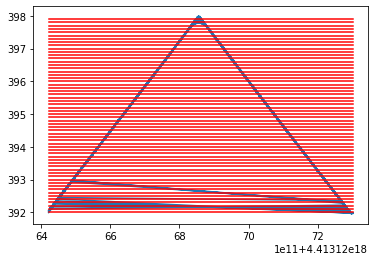

In [19]:
# Construct filter
I0_lim = [0.01e6, 0.5e6]
I1_lim = [0.0, 5.0e6]
ampl_lim = [0.0, 4.0]
fltpos_lim = [20, 1000]
fltposfwhm_lim = [1, 300]
good_shots_off = ((data['xray_status']==1) & 
             (I0 > I0_lim[0]) &
             (I0 < I0_lim[1]) &
             (I1 > I1_lim[0]) &
             (I1 < I1_lim[1]))
good_shots_on = (good_shots_off &
             (data['ampl'] > ampl_lim[0]) &
             (data['ampl'] < ampl_lim[1]) &
             (data['fltpos'] > fltpos_lim[0]) &
             (data['fltpos'] < fltpos_lim[1]) &
             (data['fltposfwhm'] > fltposfwhm_lim[0]) &
             (data['fltposfwhm'] < fltposfwhm_lim[1]))


off_shots = good_shots_off & (data['laser_status'] == 0)
on_shots = good_shots_on & (data['laser_status'] == 1)
#on_shots = good_shots_off & (data['laser_status'] == 1)

# define bins
#bins = np.arange(392.1,402.1,0.1)
bins = np.arange(392.0,398.0,0.1)

mono0 = data['mono_encoder']
ts = data['timestamp']

plt.figure()
plt.plot(ts,mono)

for i in np.arange(len(bins)):
    plt.plot([np.amin(ts),np.amax(ts)], [bins[i],bins[i]], 'r')

In [20]:
print(len((data['laser_status'])))
print(len(ts[data['laser_status'] == 1]))
print(len(ts[data['laser_status'] == 0]))
print(len(ts[on_shots]))
print(len(ts[off_shots]))
print(len(ts[good_shots_on]))
print(len(ts[good_shots_off]))

24599
12299
12300
11922
12008
11922
24027


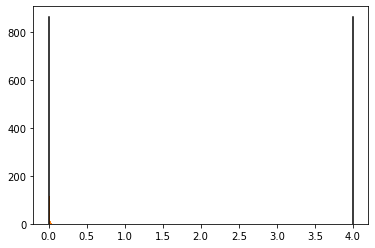

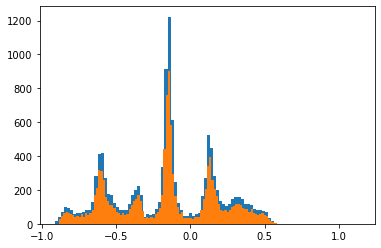

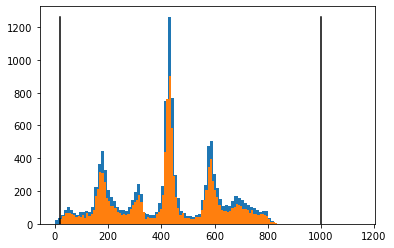

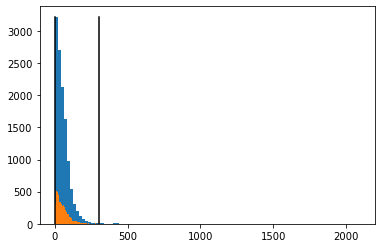

In [21]:
plt.figure()#
hh, edges, patches = plt.hist(data['ampl'], bins=100)
plt.plot([ampl_lim[0], ampl_lim[0]],[0,np.amax(hh)], 'k')
plt.plot([ampl_lim[1], ampl_lim[1]],[0,np.amax(hh)], 'k')
hh, edges, patches = plt.hist(data['ampl'][on_shots], bins=100)
plt.figure()#
hh, edges, patches = plt.hist(data['fltpos_ps'], bins=100)
hh, edges, patches = plt.hist(data['fltpos_ps'][on_shots], bins=100)
plt.figure()#
hh, edges, patches = plt.hist(data['fltpos'], bins=100)
plt.plot([fltpos_lim[0], fltpos_lim[0]],[0,np.amax(hh)], 'k')
plt.plot([fltpos_lim[1], fltpos_lim[1]],[0,np.amax(hh)], 'k')
hh, edges, patches = plt.hist(data['fltpos'][on_shots], bins=100)
plt.figure()#
hh, edges, patches = plt.hist(data['fltposfwhm'], bins=100)
plt.plot([fltposfwhm_lim[0], fltposfwhm_lim[0]],[0,np.amax(hh)], 'k')
plt.plot([fltposfwhm_lim[1], fltposfwhm_lim[1]],[0,np.amax(hh)], 'k')
hh, edges, patches = plt.hist(data['fltposfwhm'][on_shots], bins=100)

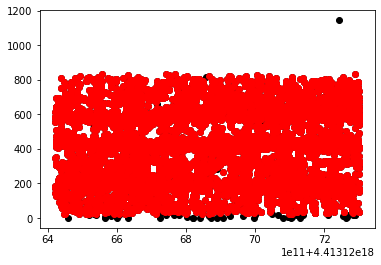

In [22]:
plt.figure()
plt.plot(ts, data['fltpos'], 'ko')
plt.plot(ts[on_shots], data['fltpos'][on_shots], 'ro')

[6.90713244] [0.0025394]


"\nfname = 'mono_encoder_run%03d.h5' %(run)\nstore_data(fname, {'mono_encoder': encoder_fit,\n                   'pitch': pitch_fit\n                  })\nprint('Stored data in %s' %fname)\n"

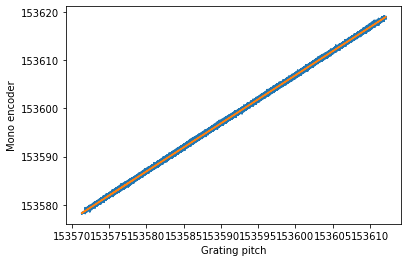

In [23]:
# check encoder to pitch offset

#plt.figure()
#plt.plot(data['mono_encoder'],data['mono_grating_pitch'])
#plt.plot(data['mono_encoder'],encoder2pitch(data['mono_encoder']))

pitch = data['mono_grating_pitch']
encoder = data['mono_encoder']
good_steps = (np.isfinite(pitch) & np.isfinite(encoder))
pitch_fit = pitch[good_steps]
encoder_fit = encoder[good_steps]

res = linregress(pitch_fit, encoder_fit)
fit = res.intercept + res.slope*pitch_fit
def model(x,a):
    y = a + x
    return y
popt1, pcov1 = curve_fit(model, pitch_fit, encoder_fit, p0=(res.intercept))
perr1 = np.sqrt(np.diag(pcov1))
fit1 = model(pitch_fit,*popt1)

plt.figure()
plt.plot(pitch_fit, encoder_fit)
#plt.plot(pitch_fit, fit)
plt.plot(pitch_fit, fit1)
plt.xlabel('Grating pitch')
plt.ylabel('Mono encoder')
#print(res)
print(popt1,perr1)

'''
fname = 'mono_encoder_run%03d.h5' %(run)
store_data(fname, {'mono_encoder': encoder_fit,
                   'pitch': pitch_fit
                  })
print('Stored data in %s' %fname)
'''

Saved file Andor_DIR_trace_run093.png
Saved file Andor_DIR_hist_run093.png


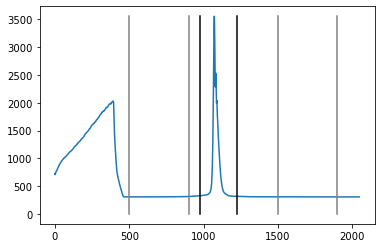

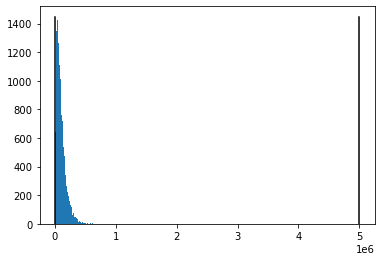

In [24]:
andor_sum = np.sum(data['andor_dir'], axis=0)

plt.figure()
plt.plot(andor_sum/nevents)
plt.plot([andor_signal[0], andor_signal[0]], [0, np.amax(andor_sum/nevents)], 'k-')
plt.plot([andor_signal[1], andor_signal[1]], [0, np.amax(andor_sum/nevents)], 'k-')
plt.plot([andor_bckg1[0], andor_bckg1[0]], [0, np.amax(andor_sum/nevents)], '0.5')
plt.plot([andor_bckg1[1], andor_bckg1[1]], [0, np.amax(andor_sum/nevents)], '0.5')
plt.plot([andor_bckg2[0], andor_bckg2[0]], [0, np.amax(andor_sum/nevents)], '0.5')
plt.plot([andor_bckg2[1], andor_bckg2[1]], [0, np.amax(andor_sum/nevents)], '0.5')

outname1 = 'Andor_DIR_trace_run%03d' %(run)
plt.savefig(outname1+'.png',dpi=300)
print('Saved file '+outname1+'.png')

plt.figure()#
I1_hist, I1_edges, patches = plt.hist(I1, bins=100)
plt.plot([I1_lim[0], I1_lim[0]],[0,np.amax(I1_hist)], 'k')
plt.plot([I1_lim[1], I1_lim[1]],[0,np.amax(I1_hist)], 'k')

outname1 = 'Andor_DIR_hist_run%03d' %(run)
plt.savefig(outname1+'.png',dpi=300)
print('Saved file '+outname1+'.png')

24135
464
Saved file Andor_VLS_trace_run093.png
Saved file Andor_VLS_hist_run093.png


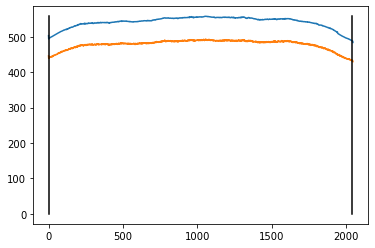

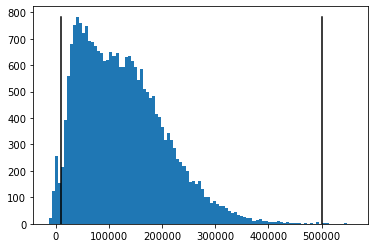

In [25]:


andorvls_xrayOn = data['andor_vls'][data['xray_status']==1]
andorvls_xrayOff = data['andor_vls'][data['xray_status']==0]

andorvls_mean = np.mean(andorvls_xrayOn, axis=0)

plt.figure()
plt.plot(andorvls_mean)
plt.plot(andorvls_bckg)
plt.plot([andorvls_signal[0], andorvls_signal[0]], [0, np.amax(andorvls_mean)], 'k-')
plt.plot([andorvls_signal[1], andorvls_signal[1]], [0, np.amax(andorvls_mean)], 'k-')

print(len(andorvls_xrayOn[:,0]))
print(len(andorvls_xrayOff[:,0]))

outname1 = 'Andor_VLS_trace_run%03d' %(run)
plt.savefig(outname1+'.png',dpi=300)
print('Saved file '+outname1+'.png')

plt.figure()#
I0_hist, I0_edges, patches = plt.hist(I0, bins=100)
plt.plot([I0_lim[0], I0_lim[0]],[0,np.amax(I0_hist)], 'k')
plt.plot([I0_lim[1], I0_lim[1]],[0,np.amax(I0_hist)], 'k')

outname1 = 'Andor_VLS_hist_run%03d' %(run)
plt.savefig(outname1+'.png',dpi=300)
print('Saved file '+outname1+'.png')

Text(0.5, 1.0, 'FIM2 channel7, APD')

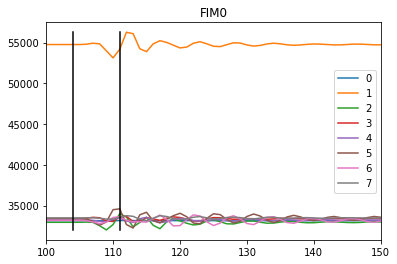

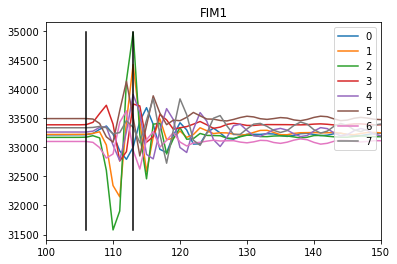

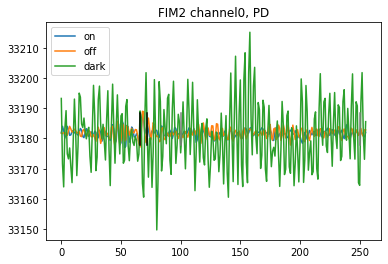

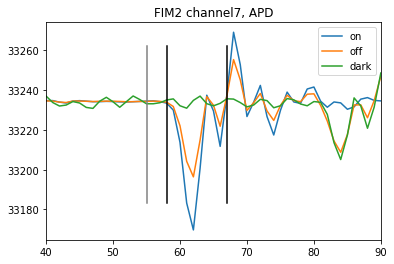

In [26]:
plt.figure()
for i in np.arange(8):
    plt.plot(fim0_trace[i,:],label=str(i))
plt.plot([fim0_signal[0], fim0_signal[0]], [np.amin(fim0_trace), np.amax(fim0_trace)], 'k-')
plt.plot([fim0_signal[1], fim0_signal[1]], [np.amin(fim0_trace), np.amax(fim0_trace)], 'k-')
plt.xlim([100, 150])
plt.legend()
plt.title('FIM0')
    
plt.figure()
for i in np.arange(8):
    plt.plot(fim1_trace[i,:],label=str(i))
plt.plot([fim1_signal[0], fim1_signal[0]], [np.amin(fim1_trace), np.amax(fim1_trace)], 'k-')
plt.plot([fim1_signal[1], fim1_signal[1]], [np.amin(fim1_trace), np.amax(fim1_trace)], 'k-')
plt.xlim([100, 150])
plt.legend()
plt.title('FIM1')

plt.figure()
plt.plot(fim2on_trace[0,:],label='on')
plt.plot(fim2off_trace[0,:],label='off')
plt.plot(fim2dark_trace[0,:],label='dark')
plt.plot([pd_bckg[0], pd_bckg[0]], [np.amin(fim2_trace[0,:]), np.amax(fim2_trace[0,:])], '0.5')
plt.plot([pd_bckg[1], pd_bckg[1]], [np.amin(fim2_trace[0,:]), np.amax(fim2_trace[0,:])], '0.5')
plt.plot([pd_signal[0], pd_signal[0]], [np.amin(fim2_trace[0,:]), np.amax(fim2_trace[0,:])], 'k-')
plt.plot([pd_signal[1], pd_signal[1]], [np.amin(fim2_trace[0,:]), np.amax(fim2_trace[0,:])], 'k-')
#plt.xlim([40, 90])
plt.legend()
plt.title('FIM2 channel0, PD')

plt.figure()
plt.plot(fim2on_trace[7,:],label='on')
plt.plot(fim2off_trace[7,:],label='off')
plt.plot(fim2dark_trace[7,:],label='dark')
plt.plot([apd_bckg[0], apd_bckg[0]], [np.amin(fim2_trace[7,:]), np.amax(fim2_trace[7,:])], '0.5')
plt.plot([apd_bckg[1], apd_bckg[1]], [np.amin(fim2_trace[7,:]), np.amax(fim2_trace[7,:])], '0.5')
plt.plot([apd_signal[0], apd_signal[0]], [np.amin(fim2_trace[7,:]), np.amax(fim2_trace[7,:])], 'k-')
plt.plot([apd_signal[1], apd_signal[1]], [np.amin(fim2_trace[7,:]), np.amax(fim2_trace[7,:])], 'k-')
plt.xlim([40, 90])
plt.legend()
plt.title('FIM2 channel7, APD')

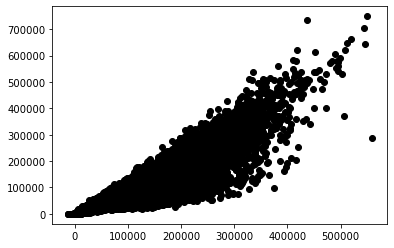

In [27]:
plt.figure()
plt.plot(I0,I1,'ok')

Saved file TXAS_I1_run093.png
Saved file TXAS_I0_run093.png
Saved file TXAS_run093.png
Saved file TXAS_FIM_run093.png
Saved file PD_run093.png
Saved file APD_run093.png
Stored data in data_run093.h5


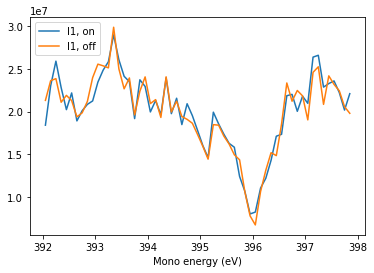

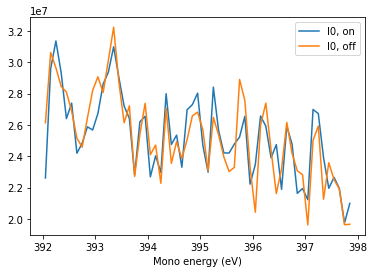

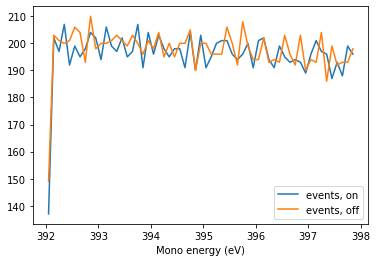

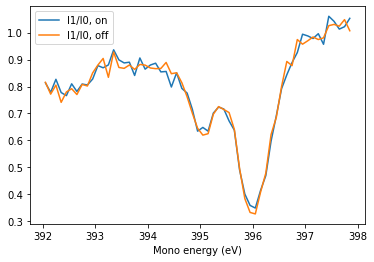

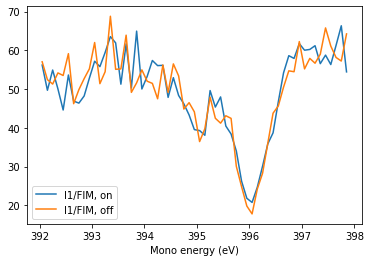

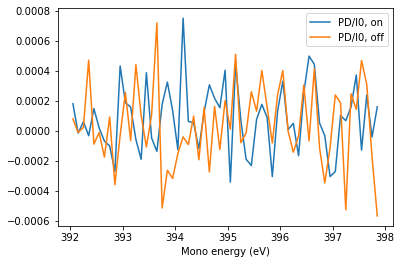

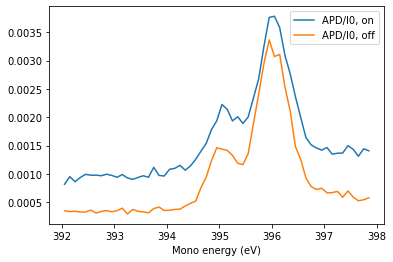

In [28]:
# binning and normalization

hist1on,bin_edges1 = np.histogram(mono[on_shots],bins=bins,weights=I1[on_shots])
hist1off,bin_edges1 = np.histogram(mono[off_shots],bins=bins,weights=I1[off_shots])
centers = 0.5*(bin_edges1[1:]+bin_edges1[:-1])

pdon,bin_edges1 = np.histogram(mono[on_shots],bins=bins,weights=fim2_pd[on_shots])
pdoff,bin_edges1 = np.histogram(mono[off_shots],bins=bins,weights=fim2_pd[off_shots])

apdon,bin_edges1 = np.histogram(mono[on_shots],bins=bins,weights=-fim2_apd[on_shots])
apdoff,bin_edges1 = np.histogram(mono[off_shots],bins=bins,weights=-fim2_apd[off_shots])

hist0on,bin_edges0 = np.histogram(mono[on_shots],bins=bins,weights=I0[on_shots])
hist0off,bin_edges0 = np.histogram(mono[off_shots],bins=bins,weights=I0[off_shots])

hist0on_fim,bin_edges0 = np.histogram(mono[on_shots],bins=bins,weights=I0_fim[on_shots])
hist0off_fim,bin_edges0 = np.histogram(mono[off_shots],bins=bins,weights=I0_fim[off_shots])

events0on,bin_edges0 = np.histogram(mono[on_shots],bins=bins)
events0off,bin_edges0 = np.histogram(mono[off_shots],bins=bins)

plt.figure()
plt.plot(centers, hist1on, label='I1, on')
plt.plot(centers, hist1off, label='I1, off')
plt.legend()
plt.xlabel('Mono energy (eV)')

outname1 = 'TXAS_I1_run%03d' %(run)
plt.savefig(outname1+'.png',dpi=300)
print('Saved file '+outname1+'.png')

plt.figure()
plt.plot(centers, hist0on, label='I0, on')
plt.plot(centers, hist0off, label='I0, off')
plt.legend()
plt.xlabel('Mono energy (eV)')

outname1 = 'TXAS_I0_run%03d' %(run)
plt.savefig(outname1+'.png',dpi=300)
print('Saved file '+outname1+'.png')

plt.figure()
plt.plot(centers, events0on, label='events, on')
plt.plot(centers, events0off, label='events, off')
plt.legend()
plt.xlabel('Mono energy (eV)')

txas_on = hist1on/hist0on
txas_off = hist1off/hist0off
#txas_fim = hist1/hist0_fim
plt.figure()
plt.plot(centers, txas_on, label='I1/I0, on')
plt.plot(centers, txas_off, label='I1/I0, off')
#plt.plot(centers, txas_fim/np.sum(txas_fim)*np.sum(txas), label='I1/FIM')
#plt.ylim([0,12])
plt.legend()
plt.xlabel('Mono energy (eV)')

outname1 = 'TXAS_run%03d' %(run)
plt.savefig(outname1+'.png',dpi=300)
print('Saved file '+outname1+'.png')

txas_on_fim = hist1on/hist0on_fim
txas_off_fim = hist1off/hist0off_fim
#txas_fim = hist1/hist0_fim
plt.figure()
plt.plot(centers, txas_on_fim, label='I1/FIM, on')
plt.plot(centers, txas_off_fim, label='I1/FIM, off')
#plt.plot(centers, txas_fim/np.sum(txas_fim)*np.sum(txas), label='I1/FIM')
#plt.ylim([0,12])
plt.legend()
plt.xlabel('Mono energy (eV)')

outname1 = 'TXAS_FIM_run%03d' %(run)
plt.savefig(outname1+'.png',dpi=300)
print('Saved file '+outname1+'.png')

pd_on = pdon/hist0on
pd_off = pdoff/hist0off
#txas_fim = hist1/hist0_fim
plt.figure()
plt.plot(centers, pd_on, label='PD/I0, on')
plt.plot(centers, pd_off, label='PD/I0, off')
#plt.plot(centers, txas_fim/np.sum(txas_fim)*np.sum(txas), label='I1/FIM')
#plt.ylim([0,12])
plt.legend()
plt.xlabel('Mono energy (eV)')

outname1 = 'PD_run%03d' %(run)
plt.savefig(outname1+'.png',dpi=300)
print('Saved file '+outname1+'.png')

apd_on = apdon/hist0on
apd_off = apdoff/hist0off
#txas_fim = hist1/hist0_fim
plt.figure()
plt.plot(centers, apd_on, label='APD/I0, on')
plt.plot(centers, apd_off, label='APD/I0, off')
#plt.plot(centers, txas_fim/np.sum(txas_fim)*np.sum(txas), label='I1/FIM')
#plt.ylim([0,12])
plt.legend()
plt.xlabel('Mono energy (eV)')

outname1 = 'APD_run%03d' %(run)
plt.savefig(outname1+'.png',dpi=300)
print('Saved file '+outname1+'.png')
            
fname = 'data_run%03d.h5' %(run)
store_data(fname, {'I1_on': hist1on,
                   'I1_off': hist1off,
                   'PD_on': pdon,
                   'PD_off': pdoff,
                   'APD_on': apdon,
                   'APD_off': apdoff,
                   'I0_on': hist0on,
                   'I0_off': hist0off,
                   'FIM_on': hist0on_fim,
                   'FIM_off': hist0off_fim,
                   'events_on': events0on,
                   'events_off': events0off,
                   'mono': centers
                  })
print('Stored data in %s' %fname)

In [29]:
txas_fit

NameError: name 'txas_fit' is not defined

In [ ]:
photons_bin

In [ ]:
sigma_I1/photons_bin

In [ ]:
sigma*np.sqrt(events_bin)

In [ ]:
sigma_I1/photons_bin*np.sqrt(events_bin)

In [ ]:
1/np.sqrt(np.mean(hist0/events0)*3.68/400)

In [ ]:
1/np.sqrt(np.mean(hist1/events0)*3.68/400)

In [ ]:
plt.figure()
plt.plot(ts,data['fim0_sum'][:,5])